In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [143]:
class FluxLimiterSolver:

    def __init__(self, limiter, init_cond,
                  N_grid, t_final=50.0, R=0.75, x_min=-5.0, x_max=5.0):
        """
        limiter  : 'minmod', 'vanleer', or 'roe'
        init_cond: 'gauss' or 'step'
        """
        self.N_grid   = N_grid
        self.x_min    = x_min
        self.x_max    = x_max
        self.t_final  = t_final
        self.limiter  = limiter
        self.init_cond= init_cond
        self.R        = R

        self.grid = np.linspace(x_min, x_max, N_grid)
        self.dx   = self.grid[1] - self.grid[0]
        self.a    = 1.0 
        self.dt = R * self.dx / abs(self.a)

        self.u = self._initial_cond()

    def _initial_cond(self):
        
        x_val = self.grid
        if self.init_cond == 'gaussian':
            return 100.0 * np.exp(-10.0 * x_val**2)
        
        elif self.init_cond == 'step':
            u = np.zeros_like(x_val)
            u[(x_val >= -1.0) & (x_val < 0.0)] = 1.0
            u[(x_val >= 0.0) & (x_val < 1.0)] = -1.0
            return u
        else:
            raise ValueError("Wrong initial condition")
        
    # Limiters are function of theta
    def minmod(self, theta):
        m1 = np.minimum(1, theta)
        return np.maximum(0, m1)

    def vanleer(self, theta):
        return (theta + np.abs(theta)) / (1 + np.abs(theta))

    def roe(self, theta):
        m1 = np.minimum(1, 2*theta)
        m2 = np.minimum(theta,2)
        return np.maximum(0, m1, m2)

    def phi(self, theta):
        if self.limiter == 'minmod':
            return self.minmod(theta)
        elif self.limiter == 'vanleer':
            return self.vanleer(theta)
        elif self.limiter == 'roe':
            return self.roe(theta)
        else:
            raise ValueError("limiter must be 'minmod','vanleer','roe'")
        
    def compute_fluxes(self, u, dt):

        a, dx = self.a, self.dx
        N = len(u)
        # flux value on the grid boundary
        grid_bound = np.zeros(N+1)
        grid_bound[1:] = u
        grid_bound[0]  = u[-2]

        # low‐order upwind flux
        F_low = a * grid_bound  

        # high‐order Lax‐Wendroff flux
        F_high = a * grid_bound[:-1] + 0.5*a*(1 - a*dt/dx)*(grid_bound[1:] - grid_bound[:-1])
        F_high = np.insert(F_high, -1, F_high[0])

        # compute smoothness ratio r_i at grid boundary
        num = u[1:] - u[:-1]
        num = np.insert(num, 0, u[-1] - u[-2])
        dem = u[1:] - u[:-1] + 1e-10
        dem = np.insert(dem, -1, u[-1] - u[-2] + 1e-16)
        r = num/dem
        left_boundary = (u[-1] - u[-2]) / (u[1] - u[-1] + 1e-16)
        r = np.insert(r, 0, left_boundary) 
        phi = self.phi(r)
        
        # limited flux
        F = F_low + phi * (F_high - F_low)
        return F

    def update(self,dt):

        F = self.compute_fluxes(self.u, dt)
        # F(u_j, u_j+1) - F(u_j-1, u_j)
        res = F[1:] - F[:-1]
        self.u = self.u - (self.dt/self.dx) * res

    def solve(self):

        t = 0.0
        dt = self.dt
        while t < self.t_final:
            
            if t > (self.t_final - dt):
                # This step ensures that the final step updates exactly to t_final
                dt = self.t_final - t
            t = t + dt

            self.update(dt)
    
    def result(self):

            self.solve()
            u_num = self.u
            # simpler: exact = initial_cond at x_c - a*t_final mod domain
            L = self.x_max - self.x_min
            x_shift = ((self.grid - self.a*self.t_final - self.x_min) % L) + self.x_min

            if self.init_cond == 'gaussian':
                u_ex = 100.0 * np.exp(-10.0 * x_shift**2)
            else:
                u_ex = np.zeros_like(x_shift)
                u_ex[(x_shift >= -1.0) & (x_shift < 0.0)] = 1.0
                u_ex[(x_shift >= 0.0) & (x_shift < 1.0)] = -1.0

            err = np.abs(u_num - u_ex)
            L2   = np.sqrt(np.sum(err**2)*self.dx)
            Linf = np.max(err)

            return {'init': self.init_cond,
                'limiter': self.limiter,
                'Grid': self.N_grid,
                'L_2 error':       L2,
                'L_inf error':     Linf,
                'numerical solution': u_num,
                'exact solution':  u_ex
            }

In [144]:
init_1 = 'gaussian'
limiter_list = ['minmod','vanleer','roe']
grids = [300, 600]

all_results_1 = {N: {} for N in grids}

for N in grids:
    for limiter in limiter_list:
        solver = FluxLimiterSolver(limiter = limiter, init_cond = init_1, N_grid = N)
        results = solver.result()  
        all_results_1[N][limiter] = results

In [145]:
rows = []
for limiter in limiter_list:
    L2_300   = all_results_1[300][limiter]['L_2 error']
    Linf_300 = all_results_1[300][limiter]['L_inf error']
    L2_600   = all_results_1[600][limiter]['L_2 error']
    Linf_600 = all_results_1[600][limiter]['L_inf error']

    conv_L2   = np.log(L2_300 / L2_600) / np.log(2)
    conv_Linf = np.log(Linf_300 / Linf_600) / np.log(2)
    rows.append({
        'limiter':        limiter,
        'L2 (N=300)':     L2_300,
        'Linf (N=300)':   Linf_300,
        'L2 (N=600)':     L2_600,
        'Linf (N=600)':   Linf_600,
        'conv rate L2':   conv_L2,
        'conv rate Linf': conv_Linf
    })

df = pd.DataFrame(rows)
print(df)

   limiter  L2 (N=300)  Linf (N=300)  L2 (N=600)  Linf (N=600)  conv rate L2  \
0   minmod   16.627931     30.994909    6.796322     15.334558      1.290783   
1  vanleer    7.673143     15.276250    2.772993      6.069664      1.468374   
2      roe   11.811657     21.746259    5.482085      9.391900      1.107415   

   conv rate Linf  
0        1.015245  
1        1.331602  
2        1.211278  


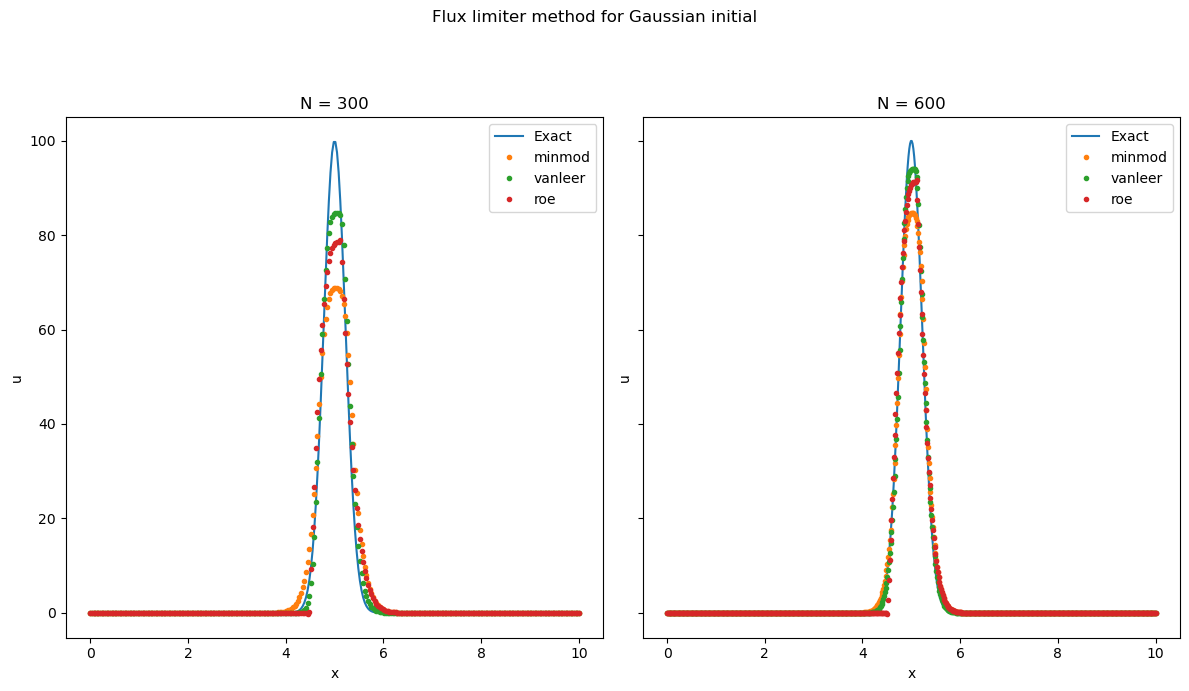

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)
for N, ax in zip(grids, axes):

    exact = True
    for limiter in limiter_list:
        d = all_results_1[N][limiter]
        plot_grid = np.linspace(0.0, 10.0, N)
        if exact == True:
            ax.plot(plot_grid, d['exact solution'], '-', label='Exact')
        ax.plot(plot_grid, d['numerical solution'], 'o', markersize=3, label=f'{limiter}')

        exact=False

    ax.set_title(f'N = {N}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
fig.suptitle(f'Flux limiter method for Gaussian initial')
plt.tight_layout(rect=[0,0,1,0.92])
plt.show()

In [147]:
init_2 = 'step'
limiter_list = ['minmod','vanleer','roe']
grids = [300, 600]

all_results_2 = {N: {} for N in grids}

for N in grids:
    for limiter in limiter_list:
        solver = FluxLimiterSolver(limiter = limiter, init_cond = init_2, N_grid = N)
        results = solver.result()  
        all_results_2[N][limiter] = results

In [148]:
rows = []
for limiter in limiter_list:
    L2_300   = all_results_2[300][limiter]['L_2 error']
    Linf_300 = all_results_2[300][limiter]['L_inf error']
    L2_600   = all_results_2[600][limiter]['L_2 error']
    Linf_600 = all_results_2[600][limiter]['L_inf error']

    conv_L2   = np.log(L2_300 / L2_600) / np.log(2)
    conv_Linf = np.log(Linf_300 / Linf_600) / np.log(2)
    rows.append({
        'limiter':        limiter,
        'L2 (N=300)':     L2_300,
        'Linf (N=300)':   Linf_300,
        'L2 (N=600)':     L2_600,
        'Linf (N=600)':   Linf_600,
        'conv rate L2':   conv_L2,
        'conv rate Linf': conv_Linf
    })

df = pd.DataFrame(rows)
print(df)

   limiter  L2 (N=300)  Linf (N=300)  L2 (N=600)  Linf (N=600)  conv rate L2  \
0   minmod    0.518634      0.981745    0.414169      0.973826      0.324496   
1  vanleer    0.411535      0.945447    0.321062      0.924467      0.358162   
2      roe    0.503060      0.984745    0.403330      1.031172      0.318769   

   conv rate Linf  
0        0.011685  
1        0.032375  
2       -0.066462  


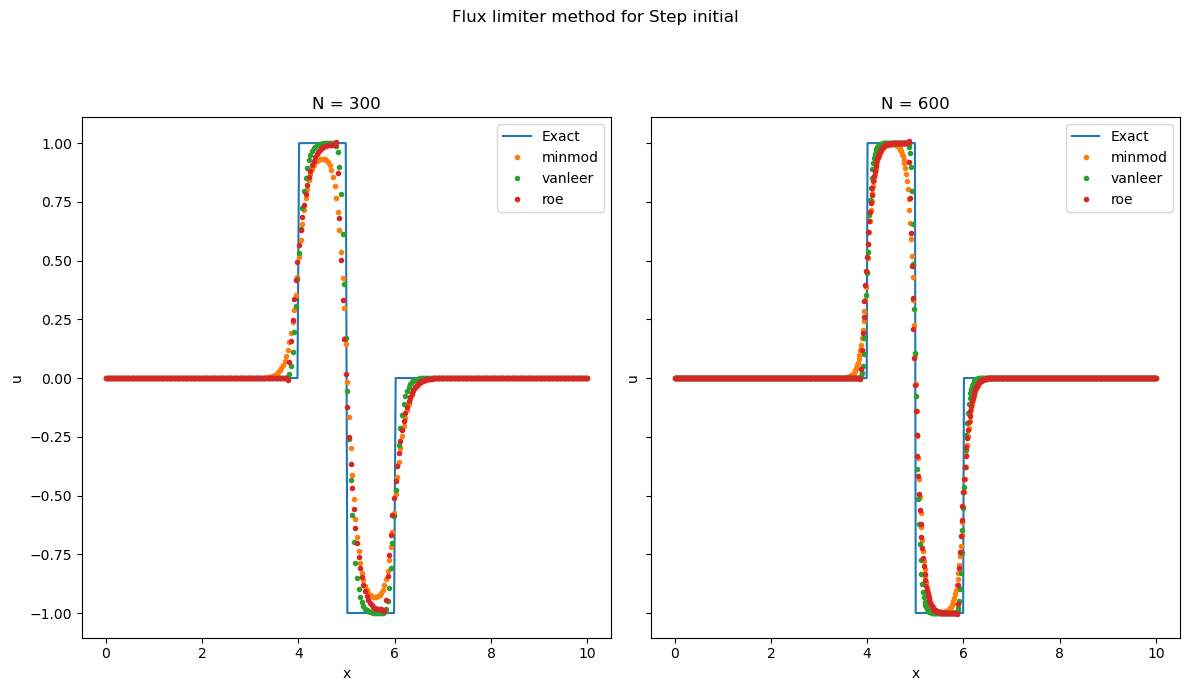

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)
for N, ax in zip(grids, axes):

    exact = True
    for limiter in limiter_list:
        d = all_results_2[N][limiter]
        plot_grid = np.linspace(0.0, 10.0, N)
        if exact == True:
            ax.plot(plot_grid, d['exact solution'], '-', label='Exact')
        ax.plot(plot_grid, d['numerical solution'], 'o', markersize=3, label=f'{limiter}')

        exact=False

    ax.set_title(f'N = {N}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
fig.suptitle(f'Flux limiter method for Step initial')
plt.tight_layout(rect=[0,0,1,0.92])
plt.show()